# [Double-Hard Debias: Tailoring Word Embeddings for Gender Bias Mitigation](https://arxiv.org/abs/2005.00965)

For more detailed explanations, please refer to the paper.

### Load embeddings

In [1]:
import gensim
import codecs
import numpy as np
from numpy import linalg as LA
import scipy
import codecs, os, json
import operator
import pickle
%load_ext autoreload
%autoreload 2

def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

def load_w2v(file_path):
    model =gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
    vocab = sorted([w for w in model.vocab], key=lambda w: model.vocab[w].index)
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = [model[w] for w in vocab]
    wv = np.array(wv)
    print(len(vocab), wv.shape, len(w2i))
    
    return wv, w2i, vocab

In [2]:
file_path_wv = './data/GoogleNews-vectors-negative300.bin'
file_path_hd = './data/GoogleNews-vectors-negative300-hard-debiased.bin'

wv, w2i, vocab = load_w2v(file_path_wv)
hd_wv, hd_w2i, hd_vocab = load_w2v(file_path_hd)

3000000 (3000000, 300) 3000000
3000000 (3000000, 300) 3000000


In [3]:
# def load_glove_p(path):
    
#     debiased_embeds = pickle.load(open(path, 'rb'))
#     wv = []
#     vocab = []
#     for w in debiased_embeds:
#         print(w)
#         print(debiased_embeds[w])
#         wv.append(np.array(debiased_embeds[w]))
#         vocab.append(str(w))
        
#     w2i = {w: i for i, w in enumerate(vocab)}
#     wv = np.array(wv).astype(float)
#     print(len(vocab), wv.shape, len(w2i))
        
#     return wv, w2i, vocab
    
# dhd_wv, dhd_w2i, dhd_vocab = load_glove_p("./data/dhd_word2vec_reproduce.p")


def load_glove_p(path):
    # Modified from original because we did not pickle a map but rather wv_f directly
    wv = pickle.load(open(path, 'rb'))
    print(wv.shape)
    return wv
dhd_wv = load_glove_p("./data/dhd_word2vec_reproduce.p")
dhd_w2i = w2i
dhd_vocab = vocab

(3000000, 300)


In [4]:
def simi(a, b):
    return 1-scipy.spatial.distance.cosine(a, b)

### Analogy & Concept Categorization

In [5]:
# Results may vary a bit if you change the algorithm in function "evaluate_categorization" in eval.py
from eval import evaluate_cate, evaluate_ana, evaluate_analogy_google, evaluate_analogy_msr

In [6]:
evaluate_cate(wv, w2i, vocab)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['acceptance']" is assigned class legal_document
exist 397 in 402
Cluster purity on AP 0.6448362720403022
Sample data from ESSLI_2c, num of samples: 45 : "['run']" is assigned class motionManner-motion
exist 45 in 45
Cluster purity on ESSLI_2c 0.6444444444444445
Sample data from ESSLI_2b, num of samples: 40 : "['chicken']" is assigned class HI
exist 40 in 40
Cluster purity on ESSLI_2b 0.8
Sample data from ESSLI_1a, num of samples: 44 : "['boat']" is assigned class vehicle-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7954545454545455
Sample data from Battig, num of samples: 5231 : "knife" is assigned class weapon
exist 3957 in 5231
Cluster purity on Battig 0.47990902198635327
Sample data from BLESS, num of samples: 200 : "['bomb']" is assigned class weapon
exist 199 in 200
Cluster purity on BLESS 0.7889447236180904


In [7]:
evaluate_cate(hd_wv, hd_w2i, hd_vocab)
evaluate_cate(dhd_wv, dhd_w2i, dhd_vocab)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['acceptance']" is assigned class legal_document
exist 397 in 402
Cluster purity on AP 0.6876574307304786
Sample data from ESSLI_2c, num of samples: 45 : "['run']" is assigned class motionManner-motion
exist 45 in 45
Cluster purity on ESSLI_2c 0.6444444444444445
Sample data from ESSLI_2b, num of samples: 40 : "['chicken']" is assigned class HI
exist 40 in 40
Cluster purity on ESSLI_2b 0.8
Sample data from ESSLI_1a, num of samples: 44 : "['boat']" is assigned class vehicle-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7727272727272727
Sample data from Battig, num of samples: 5231 : "knife" is assigned class weapon
exist 3957 in 5231
Cluster purity on Battig 0.5099823098306797
Sample data from BLESS, num of samples: 200 : "['bomb']" is assigned class weapon
exist 199 in 200
Cluster purity on BLESS 0.7889447236180904
Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['a

In [8]:
# evaluate_ana(hd_wv, hd_w2i, hd_vocab)
# evaluate_ana(dhd_wv, dhd_w2i, dhd_vocab)

In [9]:
# evaluate_ana(dhd_wv, dhd_w2i, dhd_vocab)

### Restrict vocabulary

In [10]:
import json
from tqdm import tqdm
from utils import limit_vocab

gender_specific = []

with open('./data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
print(len(gender_specific))

with codecs.open('./data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))
with codecs.open('./data/definitional_pairs.json') as f:
    definitional_pairs = json.load(f)
with codecs.open('./data/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)

exclude_words = gender_specific
print(len(exclude_words))

442
1883


In [11]:
from utils import limit_vocab
# create spaces of limited vocabulary
wv_vocab_limit, wv_limit, wv_w2i_limit = limit_vocab(wv, w2i, vocab, exclude = exclude_words)
hd_vocab_limit, hd_limit, hd_w2i_limit = limit_vocab(
    hd_wv, hd_w2i, hd_vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 622616.22it/s]


size of vocabulary: 26142
size of vocabulary: 26142


In [12]:
dhd_vocab_limit, dhd_limit, dhd_w2i_limit = limit_vocab(
    dhd_wv, dhd_w2i, dhd_vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 575402.44it/s]


size of vocabulary: 26142


### Select top biased words

In [13]:
he_embed = wv[w2i['he'], :]
she_embed = wv[w2i['she'], :]

def simi(a, b):
    return 1-scipy.spatial.distance.cosine(a, b)

def compute_bias_by_projection(wv, w2i, vocab):
    d = {}
    for w in vocab:
        u = wv[w2i[w], :]
        d[w] = simi(u, he_embed) - simi(u, she_embed)
    return d

gender_bias_bef = compute_bias_by_projection(wv_limit, wv_w2i_limit, wv_vocab_limit)
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))

### TSNE visualization of originally top biased words

In [14]:
def visualize(vectors, y_true, y_pred, ax, title, random_state):
    
    # perform TSNE
    vectors = normalize(vectors)
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    for x,p,y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    
    return ax

def cluster_and_visualize(words, X1, title, random_state, tsne_random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title, tsne_random_state)
    
#     fig.savefig("a_{}_{}_{}.pdf".format(title, size, random_state))

In [15]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from utils import extract_vectors
import operator
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size=500
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

precision 0.999


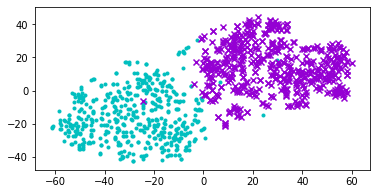

In [16]:
# You may change the random states to get more visualization result
random_state = 0
tsne_random_state = 2
cluster_and_visualize(male + female, extract_vectors(male + female, wv_limit, wv_w2i_limit), 
                          'Word2Vec', random_state, tsne_random_state, y_true)

precision 0.917


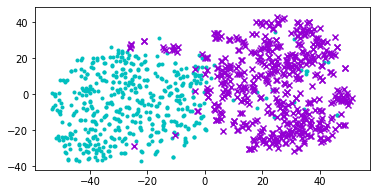

In [17]:
cluster_and_visualize(male + female, extract_vectors(male + female, hd_limit, hd_w2i_limit), 
                          'Hard Word2Vec', random_state, tsne_random_state, y_true)

precision 0.501


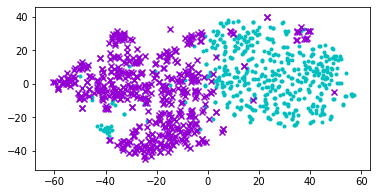

In [18]:
cluster_and_visualize(male + female, extract_vectors(male + female, dhd_limit, dhd_w2i_limit), 
                          'Double-Hard Word2Vec', random_state, tsne_random_state, y_true)

### Cluster originally top biased words
Following results may be slightly different from the numbers reported in the paper. This is due to:

1. how we select top biased words. Here, we select ones with largest similarities with **he** and **she** without normalizing embeddings, however, this may not be the perfect way. Other options can be:
    - normalize word embeddings first and then pick top biased words.
    - select according to projections on the difference vector of **he** and **she**.
2. different random state used in the clustering algorithm.

We care more about the relative clustering acc change and we see significant decrease with Double-Hard Debiased embeddings.

In [19]:
def cluster(words, X1, random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))

In [20]:
# Cluster most biased words before and after debiasing

def my_cluster(wv, w2i, start=0, size=500, random_state = 1):
    
    if start == 0:
        female = [item[0] for item in sorted_g[:size]]
        male = [item[0] for item in sorted_g[-size:]]
    else:
        female = [item[0] for item in sorted_g[start:size+start]]
        male = [item[0] for item in sorted_g[-(start+size):-start]]

    y_true = [1]*size + [0]*size
    
    cluster(male + female, extract_vectors(male + female, wv, w2i), random_state, y_true)

In [21]:
random_state_=3
start=0
end=100
my_cluster(wv_limit, wv_w2i_limit, start, end, random_state=random_state_)
my_cluster(hd_limit, hd_w2i_limit, start, end, random_state=random_state_)
my_cluster(dhd_limit, dhd_w2i_limit, start, end, random_state=random_state_)

precision 1.0
precision 0.885
precision 0.625


In [22]:
random_state_=4
start=0
end=500
my_cluster(wv_limit, wv_w2i_limit, start, end, random_state=random_state_)
my_cluster(hd_limit, hd_w2i_limit, start, end, random_state=random_state_)
my_cluster(dhd_limit, dhd_w2i_limit, start, end, random_state=random_state_)

precision 0.999
precision 0.923
precision 0.5900000000000001


In [23]:
random_state_=1
start=0
end=1000
my_cluster(wv_limit, wv_w2i_limit, start, end, random_state=random_state_)
my_cluster(hd_limit, hd_w2i_limit, start, end, random_state=random_state_)
my_cluster(dhd_limit, dhd_w2i_limit, start, end, random_state=random_state_)

precision 0.996
precision 0.8825
precision 0.602


### Classification experiment

We also test classification experiment as described in [Lipstick on a Pig](https://arxiv.org/abs/1903.03862). However, we don't see any significant improvement on any debiasing approaches. We suspect that classification may not reflect gender bia correctly as it can always find a decision boundary with supervisions which may not be gender. 

In [24]:
from sklearn import svm
from random import shuffle
import random
from utils import train_and_predict

def cls(wv, w2i, vocab, size_train, size_test):
    size = size_train + size_test
    females = [item[0] for item in sorted_g[:size]]
    males = [item[0] for item in sorted_g[-size:]]
    males.reverse()

    shuffle(females)
    shuffle(males)

    train_and_predict(wv, w2i, vocab, size_train, size_test, males, females)

In [25]:
size_train=100
size_test=1000
cls(wv_limit, wv_w2i_limit, wv_vocab_limit, size_train, size_test)
cls(hd_limit, hd_w2i_limit, hd_vocab_limit, size_train, size_test)
cls(dhd_limit, dhd_w2i_limit, dhd_vocab_limit, size_train, size_test)

accuracy: 0.99
accuracy: 0.8925
accuracy: 0.8535


In [26]:
size_train=100
size_test=2000
cls(wv_limit, wv_w2i_limit, wv_vocab_limit, size_train, size_test)
cls(hd_limit, hd_w2i_limit, hd_vocab_limit, size_train, size_test)
cls(dhd_limit, dhd_w2i_limit, dhd_vocab_limit, size_train, size_test)

accuracy: 0.96025
accuracy: 0.887
accuracy: 0.74325


### Association Experiments (Calisken et al.)

In [27]:
from utils import p_value_exhust, effect_size
from utils import WEAT_words

A = WEAT_words['A']
B = WEAT_words['B']
C = WEAT_words['C']
D = WEAT_words['D']
E = WEAT_words['E']
F = WEAT_words['F']
G = WEAT_words['G']
H = WEAT_words['H']
A = [elem for elem in A]
B = [elem for elem in B]
C = [elem for elem in C]
D = [elem for elem in D]
E = [elem for elem in E]
F = [elem for elem in F]
G = [elem for elem in G]
H = [elem for elem in H]
print(effect_size(A, B, C, D, wv, w2i, vocab))
print(effect_size(A, B, C, D, hd_wv, hd_w2i, hd_vocab))
print(effect_size(A, B, C, D, dhd_wv, dhd_w2i, dhd_vocab))
print(p_value_exhust(A, B, C, D, wv, w2i, vocab))
print(p_value_exhust(A, B, C, D, hd_wv, hd_w2i, hd_vocab))
print(p_value_exhust(A, B, C, D, dhd_wv, dhd_w2i, dhd_vocab))
print(effect_size(A, B, E, F, wv, w2i, vocab))
print(effect_size(A, B, E, F, hd_wv, hd_w2i, hd_vocab))
print(effect_size(A, B, E, F, dhd_wv, dhd_w2i, dhd_vocab))
print(p_value_exhust(A, B, E, F, wv, w2i, vocab))
print(p_value_exhust(A, B, E, F, hd_wv, hd_w2i, hd_vocab))
print(p_value_exhust(A, B, E, F, dhd_wv, dhd_w2i, dhd_vocab))
print(effect_size(A, B, G, H, wv, w2i, vocab))
print(effect_size(A, B, G, H, hd_wv, hd_w2i, hd_vocab))
print(effect_size(A, B, G, H, dhd_wv, dhd_w2i, dhd_vocab))
print(p_value_exhust(A, B, G, H, wv, w2i, vocab))
print(p_value_exhust(A, B, G, H, hd_wv, hd_w2i, hd_vocab))
print(p_value_exhust(A, B, G, H, dhd_wv, dhd_w2i, dhd_vocab))

1.8898680476730718
1.7976407447997855
1.7280481045421132
num of samples 12870
0.0
num of samples 12870
0.0
num of samples 12870
7.77000777000777e-05
1.8211261786070605
1.5731234221001178
1.5126381187959448
num of samples 12870
0.0
num of samples 12870
7.77000777000777e-05
num of samples 12870
0.0005439005439005439
1.5683047521971845
0.8360304934006898
0.6796266828702059
num of samples 12870
0.0001554001554001554
num of samples 12870
0.046620046620046623
num of samples 12870
0.09106449106449106


In [28]:
print(effect_size(A, B, C, D, wv, w2i, vocab))
print(effect_size(A, B, C, D, hd_wv, hd_w2i, hd_vocab))
print(effect_size(A, B, C, D, dhd_wv, dhd_w2i, dhd_vocab))

1.8898680476730718
1.7976407447997855
1.7280481045421132


In [29]:
print(p_value_exhust(A, B, C, D, wv, w2i, vocab))
print(p_value_exhust(A, B, C, D, hd_wv, hd_w2i, hd_vocab))
print(p_value_exhust(A, B, C, D, dhd_wv, dhd_w2i, dhd_vocab))

num of samples 12870
0.0
num of samples 12870
0.0
num of samples 12870
7.77000777000777e-05
